## Read VWC data 

In [66]:

import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import cufflinks as cf


# Import csv file with proper datetime format
df = pd.read_csv("TDR_data_clean_VWC.txt", parse_dates={'date_time': [0]}, dayfirst = True)

# Edit column header names to enable splitting later on
df.columns = (df.columns.str.replace(' ', '_').str.replace('(', '')
              .str.replace(')', '') .str.replace(',', '').str.replace('\'', '')
              .str.replace('Interface', '').str.replace('Sensor_', ''))



### Time vs VWC
Select the area you want to explore

In [13]:
import ipywidgets as wg



w1 = wg.Dropdown(
    options=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    description='Area:',
    disabled=False,
)


display(w1)




Dropdown(description='Area:', options=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), value='A')

In [21]:
import plotly.graph_objs as go

area = w1.value
sensor1 = go.Scatter(x= df['date_time'], y= df[area + "_VWC_1"])
sensor2 = go.Scatter(x= df['date_time'], y= df[area + "_VWC_2"])
sensor3 = go.Scatter(x= df['date_time'], y= df[area + "_VWC_3"])


data = [sensor1, sensor2, sensor3]

layout = go.Layout(
    title='Time vs Volumetric Water Content',
    xaxis=dict(
        title='Time',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Water Content',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='time vs VWC')



The draw time for this plot will be slow for all clients.


C:\Users\karin\Anaconda3\lib\site-packages\plotly\api\v1\clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



## Time vs Irriugation

In [70]:
import time
import datetime

irrigation_df = pd.read_csv("Irrigation.txt", parse_dates={'date_time': [0]}, dayfirst = True)

irrigation_df['date'] = pd.to_datetime(irrigation_df['date_time'])

t1 = go.Bar(
   x=irrigation_df['date'],
    y=irrigation_df['A'],
    name='Irrigation area A'
)

t2 = go.Bar(
   x=irrigation_df['date'],
    y=irrigation_df['B'],
    name='Irrigation area B'
)

t3 = go.Bar(
   x=irrigation_df['date'],
    y=irrigation_df['C'],
    name='Irrigation area C'
)

t4 = go.Bar(
   x=irrigation_df['date'],
    y=irrigation_df['D'],
    name='Irrigation area D'
)

t5 = go.Bar(
   x=irrigation_df['date'],
    y=irrigation_df['E'],
    name='Irrigation area E'
)

t6 = go.Bar(
   x=irrigation_df['date'],
    y=irrigation_df['F'],
    name='Irrigation area F'
)

t7 = go.Bar(
   x=irrigation_df['date'],
    y=irrigation_df['G'],
    name='Irrigation area G'
)

t8 = go.Bar(
   x=irrigation_df['date'],
    y=irrigation_df['H'],
    name='Irrigation area H'
)

t9 = go.Bar(
   x=irrigation_df['date'],
    y=irrigation_df['I'],
    name='Irrigation area I'
)

t10 = go.Bar(
   x=irrigation_df['date'],
    y=irrigation_df['J'],
    name='Irrigation area J'
)

data = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10]

layout = go.Layout( title='Time vs Irrigation',
    xaxis=dict(
        title='Time',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Irrigation',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ))




fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='time vs irrigation')

The draw time for this plot will be slow for all clients.


C:\Users\karin\Anaconda3\lib\site-packages\plotly\api\v1\clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



## DTW distances matrix

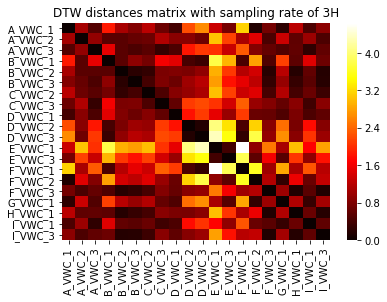

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from dtw import accelerated_dtw
from enum import Enum


class Distances:
    debug = True

    # noinspection SpellCheckingInspection
    @staticmethod
    def dtw_matrix(dataframe, sampling_rate='2H'):
        """Returns a data frame containing dynamic time warping (DTW) distances matrix of the input data frame.
            The data must not contain any NaN values.
            Args:
                :param dataframe: a data frame containing the data columns we want to compare
                :type dataframe: pandas.DataFrame

                :param sampling_rate:
                :type sampling_rate: str

            :return: a data frame containing dynamic time warping (DTW) distances matrix of the input data frame.
            :rtype: object
        """

        assert (not dataframe.isna().values.any()), "The data frame must not contain any NaN values"

        df_downsampled = dataframe.resample(sampling_rate).mean()
        values = df_downsampled.values.T
        num_interfaces, _ = values.shape
        distances_matrix = np.zeros((num_interfaces, num_interfaces))
        for i in range(num_interfaces):
            for j in range(i + 1, num_interfaces):
                d, _, _, _ = accelerated_dtw(values[i, :], values[j, :], dist=lambda x, y: np.abs(x - y))
#                 if Distances.debug:
#                     print("Finsihed comparing", dataframe.columns[i], "and", dataframe.columns[j])
                distances_matrix[i, j] = distances_matrix[j, i] = d
            # Convert into a data frame
        distances_matrix_df = (lambda v, c: pd.DataFrame(v, c, c))(distances_matrix, dataframe.columns)
        return distances_matrix_df

    # noinspection SpellCheckingInspection
    @staticmethod
    def p_norm(dataframe, p=2, matrix_dist=False):
        """ Returns a data frame containing p-norm distances matrix of the input data frame.
            The data must not contain any NaN values.

            Args:
                :param dataframe: a data frame containing the data columns we want to compare
                :type dataframe: pandas.DataFrame

                :param p: determines which p-norm to use (defaults to 2, and has to be >= 1)
                :type p: int (optional; defaults to 2)

                :param matrix_dist: if it is true, the data frame is treated as a collection of 3-columned matrices
                :type matrix_dist: bool (optional; defaults to False)

            :return: a data frame containing p-norm distances matrix of the input data frame.
            :rtype: pandas.DataFrame
        """

        assert (p >= 1 and p == int(p)), "p has to be an int >= 1"
        assert (not dataframe.isna().values.any()), "The data frame must not contain any NaN values"

        if not matrix_dist:
            # We use the transpose values matrix so the columns become row vectors for pdist
            values = dataframe.values.T
            new_cols = dataframe.columns

        else:
            num_cols = len(dataframe.columns.tolist())
            values = dataframe.values.T.reshape(int(num_cols / 3), -1)
            original_cols = dataframe.columns.tolist()
            new_cols = pd.Index(sorted(list(set([title[0] + title[-1] for title in original_cols]))))

        # calculate distances
        distances_matrix = squareform(pdist(values, metric='minkowski', p=p))
        # Convert into a data frame
        distances_matrix_df = (lambda v, c: pd.DataFrame(v, c, c))(distances_matrix, new_cols)
        return distances_matrix_df


def get_new_cols(original_cols):
    new_cols = [original_cols[0]]
    interfaces = [c + '_' for c in "ABCDEFGHI"]
    for interface in interfaces:
        for ind in ['_1', '_2', '_3']:
            for meas in ['VWC', 'Soil_Temperature', 'BulkEC']:
                new_col_title = interface + meas + ind
                if new_col_title in original_cols:
                    new_cols.append(new_col_title)
    return new_cols


class TestCase(Enum):
    VWC_P_NORM = 1
    FULL_DATA_P_NORM = 2
    VWC_DTW = 3


# Simple example
if __name__ == "__main__":

    # change this number to try different tests (see the TestCase class enumeration)
    tc = 3

    if tc == TestCase.VWC_P_NORM.value:
        # Import csv file with proper datetime format
        df = pd.read_csv("nan_reduced_VWC.txt", parse_dates={'date_time': [0]}, dayfirst=True)

        # Edit column header names to enable splitting later on
        df.columns = (df.columns.str.replace(' ', '_').str.replace('(', '')
                      .str.replace(')', '').str.replace(',', '').str.replace('\'', '')
                      .str.replace('Interface', '').str.replace('Sensor_', ''))

        # remove first column (date-time)
        df_no_date = df.drop(df.columns[0], axis=1)
        # we interpolate the dataframe in order to replace NaN values
        df_no_date_interpolated = df_no_date.interpolate()

        euclidean_dists_df = Distances.p_norm(df_no_date_interpolated)
        plt.figure()
        sns.heatmap(euclidean_dists_df, cmap="hot")
        plt.title("Euclidean distances matrix - VWC data")
        plt.show()

        L1_dists_df = Distances.p_norm(df_no_date_interpolated, p=1)
        plt.figure()
        sns.heatmap(L1_dists_df, cmap="hot")
        plt.title("L1 distances matrix - VWC data")
        plt.show()

    elif tc == TestCase.FULL_DATA_P_NORM.value:
        df2 = pd.read_csv("nan_reduced_no_permitivity.txt", parse_dates={'date_time': [0]}, dayfirst=True)

        # Edit column header names to enable splitting later on
        df2.columns = (df2.columns.str.replace(' ', '_').str.replace('(', '')
                       .str.replace(')', '').str.replace(',', '').str.replace('\'', '')
                       .str.replace('Interface', '').str.replace('Sensor_', ''))

        original_cols = df2.columns.tolist()
        new_cols = get_new_cols(original_cols)
        df2 = df2[new_cols]
        df2_no_date = df2.drop(df2.columns[0], axis=1)
        df2_no_date_interpolated = df2_no_date.interpolate()

        euclidean_dists_df2 = Distances.p_norm(df2_no_date_interpolated, matrix_dist=True)
        plt.figure()
        sns.heatmap(euclidean_dists_df2, cmap="hot")
        plt.title("Euclidean distances matrix - full data")
        plt.show()

    elif tc == TestCase.VWC_DTW.value:
        # Import csv file with proper datetime format
        df3 = pd.read_csv("nan_reduced_VWC.txt", parse_dates={'date_time': [0]}, dayfirst=True)

        # Edit column header names to enable splitting later on
        df3.columns = (df3.columns.str.replace(' ', '_').str.replace('(', '')
                       .str.replace(')', '').str.replace(',', '').str.replace('\'', '')
                       .str.replace('Interface', '').str.replace('Sensor_', ''))

        df3 = df3.set_index('date_time')

        # we interpolate the dataframe in order to replace NaN values
        df3_interpolated = df3.interpolate()

        SAMPLING_RATE = '3H'
        dtw_df = Distances.dtw_matrix(df3_interpolated, SAMPLING_RATE)
        dtw_df.to_pickle('dtw_distances_' + SAMPLING_RATE + '_sampling.pkl')
        plt.figure()
        sns.heatmap(dtw_df, cmap="hot")
        plt.title("DTW distances matrix with sampling rate of " + SAMPLING_RATE)
        plt.show()



## Hierarchical clustering

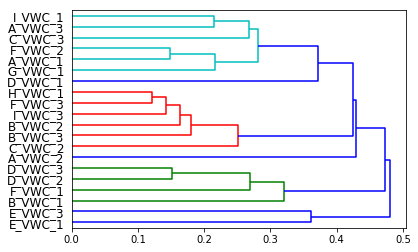

In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

df2 = pd.read_pickle('dtw_distances_H_sampling.pkl')
condensed_distance_matrix = squareform(df2.values)
Z = linkage(condensed_distance_matrix, metric='precomputed')
dendrogram(Z, orientation='right', labels=df2.columns.tolist())

plt.show()
